## Overview
The goal is to train a model that is capable of predicting ratings of HIV risk for a given photograph based on visual cues that are depicted on the photograph. We start with the training dataset that characterizes portrait photographs on i) a large number of visual cues (cue measures obtained from a large group of cue-judges) for each photograph as well as ii) ratings of HIV risk provided by actual raters (criterion variable). We then train a simple regression model, i.e. we estimate the coefficients that link the cues (X) to the HIV risk ratings (Y). This model is  applied to a test dataset to test the quality of resulting predictions, i.e. how well model-based HIV risk predictions match real-world judgments.


In [1]:
rm(list = ls())
setwd("/Users/Ralf/My_Cloud/03_PROJEKTE/CUES/Matlab/")
library(foreign) # gives read.spss function
library("ggplot2")
library('lars')

Loaded lars 1.2



### 1. Prepare data
We first read in the data and print the column/variable names.
The first part of the variable name (Cue2 ... Cue5) tells us the cue-number. 
After the variable name, we see the category to which the cue belongs: appearance, body, face, hair, mouth, set, skin, view...
Then comes the specific item (also indicating the item directionality)
Finally, we get the cue abstracness: 0 indicating very concrete and observable, 1 is a slightly more interpretive level. 

In [2]:
train_data = read.csv("setA_001-120.txt", header =TRUE, sep = "\t"); 
head(train_data)

No,Sex,BildNr,Risk,Trust,Health,Attractiveness,CUE1_Appearance1_Ungroomed..vs..groomed..appearance_Abstract_2,CUE2_Appearance2_Lot.of..vs..no..body.adornment_Abstract_0,CUE3_Appearance3_Unshaved..vs..shaved._Abstract_0,⋯,CUE64_Skin1_Unhealthy..vs..healthy..skin_Abstract_1,CUE65_Skin2_Pale..vs..tanned..skin_Abstract_0,CUE66_Skin3_Pimply..vs..pimple.free..skin_Abstract_0,CUE67_Skin4_Many..vs..few..skin.folds_Abstract_0,CUE68_Skin5_Spotty..vs..spot.free..skin_Abstract_0,CUE69_Skin6_Greasy..vs..dry..skin_Abstract_0,CUE70_Skin7_Lots.of..vs..no..skin.visible_Abstract_0,CUE71_View1_Coquettish..vs..no.coquettish..gaze_Abstract_1,CUE72_View2_Averted..vs..front.facing..gaze_Abstract_0,CUE73_View3_Tired..vs..alert..gaze_Abstract_1
1,0,1,3.550,4.150,4.200,2.775,4.500,4.125,NaN,⋯,4.375,3.250,3.750,2.500,2.875,5.625,6.125,2.0000,1.0000,3.000
2,0,2,3.500,4.125,4.775,4.525,2.750,2.125,NaN,⋯,2.750,3.250,3.125,1.500,1.750,4.000,5.250,5.1250,1.2500,4.750
3,0,3,4.775,3.725,3.775,4.275,4.625,4.625,NaN,⋯,3.000,6.000,2.375,1.625,1.500,3.250,6.625,2.5000,1.6250,4.375
4,0,4,4.475,3.300,3.800,4.225,3.625,5.125,NaN,⋯,3.500,4.875,3.375,1.250,2.250,5.000,5.000,4.5000,1.7500,4.875
5,0,5,4.725,3.825,3.725,4.175,2.375,3.250,NaN,⋯,2.375,4.750,2.250,2.000,2.625,4.250,3.125,4.5714,1.6250,2.125
6,0,6,2.675,5.075,5.175,4.100,2.250,3.000,NaN,⋯,3.500,3.875,3.125,1.500,2.250,4.000,6.375,3.5000,1.5714,3.500


In [4]:
#  reformatting - to get rid of cues that are not complete in all cases (e.g. beard for females)
train_data$CUE3_Appearance3_Unshaved..vs..shaved._Abstract_0 <- NULL
train_data$CUE34_Face17_Strong..vs..no..growth.of.beard_Abstract_0 <- NULL
train_data$CUE53_Mouth2_Yellow..vs..white..teeth_Abstract_0 <- NULL
train_data$CUE62_Set8_Dark..vs..well.lit..background_Abstract_0 <- NULL

# get rid of picture number, gender, and the other target variables trust, health, and attractiveness
train_data$No <- NULL
train_data$Sex <- NULL
train_data$BildNr <- NULL
train_data$Trust <- NULL
train_data$Health <- NULL
train_data$Attractiveness <- NULL

# for now, get rid of general impressions (these are more abstract impressions, not cues)
train_data$CUE35_GenImp1_Self.confident..vs..not._Abstract_2=NULL                
train_data$CUE36_GenImp2_Cautious..vs..risk.seeking._Abstract_2=NULL                  
train_data$CUE37_GenImp3_Uneducated..vs..educated._Abstract_2=NULL                 
train_data$CUE38_GenImp4_Southern..vs..nordic..type_Abstract_1=NULL                     
train_data$CUE39_GenImp5_Sporty..vs..unsporty._Abstract_2=NULL                        
train_data$CUE40_GenImp6_Scruffy..vs..kempt._Abstract_2=NULL               
train_data$CUE41_GenImp7_Likeable..vs..unsympathetic._Abstract_2=NULL              
train_data$CUE42_GenImp8_Attractive..vs..unattractive._Abstract_2=NULL            
train_data$CUE43_GenImp9_Irresponsible..vs..responsible._Abstract_2=NULL             
train_data$CUE44_GenImp10_Homosexual..vs..heterosexual._Abstract_2=NULL                 
train_data$CUE45_GenImp11_Popular..vs..unpopular._Abstract_2=NULL                   
train_data$CUE46_GenImp12_Selfish..vs..unselfish._Abstract_2=NULL              
train_data$CUE47_GenImp13_Ill.looking..vs..healthy.looking._Abstract_2=NULL

#colnames(train_data)

### 2. Compute correlations 
We compute the correlations between all cues and the HIV risk criterion variable

In [5]:
corrs <- cor(train_data)
round(corrs,2)
#write.table(corrs, file = "cue-correlations.csv", sep = ",", col.names = NA,
#            qmethod = "double")

,Risk,CUE1_Appearance1_Ungroomed..vs..groomed..appearance_Abstract_2,CUE2_Appearance2_Lot.of..vs..no..body.adornment_Abstract_0,CUE4_Appearance4_Worn.out..vs..intact..clothes_Abstract_1,CUE5_Appearance5_Provocative..vs..reserved..clothes_Abstract_1,CUE6_Appearance6_Unconventional..vs..conventional..appearance_Abstract_1,CUE7_Appearance7_Fashionable..vs..unfashionable..appearance_Abstract_1,CUE8_Appearance8_Dark..vs..bright..clothes_Abstract_0,CUE9_Appearance9_Clean..vs..dirty..clothes_Abstract_1,CUE10_Body1_Tense..vs..relaxed..posture_Abstract_1,⋯,CUE64_Skin1_Unhealthy..vs..healthy..skin_Abstract_1,CUE65_Skin2_Pale..vs..tanned..skin_Abstract_0,CUE66_Skin3_Pimply..vs..pimple.free..skin_Abstract_0,CUE67_Skin4_Many..vs..few..skin.folds_Abstract_0,CUE68_Skin5_Spotty..vs..spot.free..skin_Abstract_0,CUE69_Skin6_Greasy..vs..dry..skin_Abstract_0,CUE70_Skin7_Lots.of..vs..no..skin.visible_Abstract_0,CUE71_View1_Coquettish..vs..no.coquettish..gaze_Abstract_1,CUE72_View2_Averted..vs..front.facing..gaze_Abstract_0,CUE73_View3_Tired..vs..alert..gaze_Abstract_1
Risk,1.00,0.24,0.50,-0.04,0.17,0.59,0.19,0.11,-0.04,0.11,⋯,0.28,-0.08,0.19,-0.06,0.09,0.17,-0.06,0.16,0.01,0.38
CUE1_Appearance1_Ungroomed..vs..groomed..appearance_Abstract_2,0.24,1.00,0.16,0.70,-0.32,0.43,-0.54,0.04,-0.60,0.07,⋯,0.65,0.04,0.51,0.32,0.40,0.26,0.15,-0.50,0.11,0.32
CUE2_Appearance2_Lot.of..vs..no..body.adornment_Abstract_0,0.50,0.16,1.00,-0.03,0.31,0.36,0.19,0.06,-0.13,0.02,⋯,0.08,-0.07,0.15,-0.26,-0.23,0.08,-0.22,0.18,0.00,0.10
CUE4_Appearance4_Worn.out..vs..intact..clothes_Abstract_1,-0.04,0.70,-0.03,1.00,-0.35,0.22,-0.66,0.06,-0.62,-0.01,⋯,0.46,0.04,0.34,0.35,0.44,0.10,0.17,-0.46,0.15,0.16
CUE5_Appearance5_Provocative..vs..reserved..clothes_Abstract_1,0.17,-0.32,0.31,-0.35,1.00,0.04,0.43,-0.11,0.17,-0.07,⋯,-0.22,-0.27,-0.17,-0.18,-0.21,-0.06,-0.83,0.43,0.00,-0.25
CUE6_Appearance6_Unconventional..vs..conventional..appearance_Abstract_1,0.59,0.43,0.36,0.22,0.04,1.00,-0.05,0.01,-0.16,0.19,⋯,0.28,0.05,0.15,0.06,0.16,0.02,-0.01,0.02,-0.02,0.20
CUE7_Appearance7_Fashionable..vs..unfashionable..appearance_Abstract_1,0.19,-0.54,0.19,-0.66,0.43,-0.05,1.00,-0.02,0.51,-0.18,⋯,-0.45,-0.16,-0.30,-0.39,-0.32,-0.23,-0.15,0.48,-0.01,-0.10
CUE8_Appearance8_Dark..vs..bright..clothes_Abstract_0,0.11,0.04,0.06,0.06,-0.11,0.01,-0.02,1.00,-0.19,0.11,⋯,-0.08,0.10,-0.09,-0.07,-0.08,-0.14,0.09,-0.01,-0.08,0.00
CUE9_Appearance9_Clean..vs..dirty..clothes_Abstract_1,-0.04,-0.60,-0.13,-0.62,0.17,-0.16,0.51,-0.19,1.00,0.02,⋯,-0.43,-0.26,-0.37,-0.21,-0.24,-0.02,-0.01,0.29,-0.05,-0.01
CUE10_Body1_Tense..vs..relaxed..posture_Abstract_1,0.11,0.07,0.02,-0.01,-0.07,0.19,-0.18,0.11,0.02,1.00,⋯,0.15,0.17,0.08,0.11,0.01,-0.03,-0.03,-0.29,-0.01,0.09


### 3. Compute the model for the training data 
Next, we specify and estimate (train) a  model via multiple regression, and test it using a held out ('test') dataset. Specifically, we read in the test data and apply the trained model to these data by multiplying the cue-values for each test case with the beta-coefficients from the training data. This yields a predicted HIV risk value per case.

#### 3.1 Linear Regression, reduced set of cues
We use a reduced set of cues for the model. These cues have been identified via a correlation filter. Of note, this step was done in KNIME-software (www.knime.org). 

In [6]:
RegModel.reduced <- 
  lm(Risk~CUE2_Appearance2_Lot.of..vs..no..body.adornment_Abstract_0 +
       CUE4_Appearance4_Worn.out..vs..intact..clothes_Abstract_1+
       CUE5_Appearance5_Provocative..vs..reserved..clothes_Abstract_1+
       CUE6_Appearance6_Unconventional..vs..conventional..appearance_Abstract_1+
       CUE8_Appearance8_Dark..vs..bright..clothes_Abstract_0+
       CUE10_Body1_Tense..vs..relaxed..posture_Abstract_1+
       CUE12_Body3_Overweight..vs..underweight._Abstract_0+
       CUE15_Eyes1_Dark..vs..no.dark..rings.under.eyes_Abstract_0+
       CUE16_Eyes2_Reddened..vs..non.reddened..eyes_Abstract_0+
       CUE17_Eyes3_Dark..vs..bright..eyes_Abstract_0+
       CUE18_Face1_Happy..vs..sad..expression_Abstract_1+
       CUE19_Face2_Babyish..vs..mature..Face_Abstract_1+
       CUE20_Face3_Feminine..vs..masculine..face_Abstract_1+
       CUE25_Face8_Ugly..vs..beautiful..face_Abstract_1+
       CUE26_Face9_Red..vs..pale..cheeks_Abstract_0+
       CUE54_Mouth3_Full..vs..narrow..lips_Abstract_0+
       CUE55_Set1_Pallid..vs..colorful..background_Abstract_0+
       CUE56_Set2_Unorganized..vs..organized..background_Abstract_1+
       CUE57_Set3_Alcohol..vs..no.alcohol..visible_Abstract_0+
       CUE58_Set4_Picture.taken.inside..vs..outside._Abstract_0+
       CUE60_Set6_Cigarettes..vs..no.cigarettes..visible_Abstract_0+
       CUE65_Skin2_Pale..vs..tanned..skin_Abstract_0+
       CUE68_Skin5_Spotty..vs..spot.free..skin_Abstract_0+
       CUE69_Skin6_Greasy..vs..dry..skin_Abstract_0+
       CUE72_View2_Averted..vs..front.facing..gaze_Abstract_0,
   data=train_data)

coefficients.reduced = coef(RegModel.reduced)

#######


load the test dataset and apply same preprocessing steps

In [7]:
test_data = read.csv("setB_121-240.txt", header =TRUE, sep = "\t"); 

# reduce the test_data by the same variables as the train_data
test_data$CUE3_Appearance3_Unshaved..vs..shaved._Abstract_0 <- NULL
test_data$CUE34_Face17_Strong..vs..no..growth.of.beard_Abstract_0 <- NULL
test_data$CUE53_Mouth2_Yellow..vs..white..teeth_Abstract_0 <- NULL
test_data$CUE62_Set8_Dark..vs..well.lit..background_Abstract_0 <- NULL
test_data$No <- NULL
test_data$Sex <- NULL
test_data$BildNr <- NULL
test_data$Trust <- NULL
test_data$Health <- NULL
test_data$Attractiveness <- NULL

test_data$CUE35_GenImp1_Self.confident..vs..not._Abstract_2=NULL                
test_data$CUE36_GenImp2_Cautious..vs..risk.seeking._Abstract_2=NULL                  
test_data$CUE37_GenImp3_Uneducated..vs..educated._Abstract_2=NULL                 
test_data$CUE38_GenImp4_Southern..vs..nordic..type_Abstract_1=NULL                     
test_data$CUE39_GenImp5_Sporty..vs..unsporty._Abstract_2=NULL                        
test_data$CUE40_GenImp6_Scruffy..vs..kempt._Abstract_2=NULL               
test_data$CUE41_GenImp7_Likeable..vs..unsympathetic._Abstract_2=NULL              
test_data$CUE42_GenImp8_Attractive..vs..unattractive._Abstract_2=NULL            
test_data$CUE43_GenImp9_Irresponsible..vs..responsible._Abstract_2=NULL             
test_data$CUE44_GenImp10_Homosexual..vs..heterosexual._Abstract_2=NULL                 
test_data$CUE45_GenImp11_Popular..vs..unpopular._Abstract_2=NULL                   
test_data$CUE46_GenImp12_Selfish..vs..unselfish._Abstract_2=NULL              
test_data$CUE47_GenImp13_Ill.looking..vs..healthy.looking._Abstract_2=NULL



predict and assess quality


	Pearson's product-moment correlation

data:  test_data$Risk and pred_values
t = 10.65, df = 118, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5955843 0.7812901
sample estimates:
      cor 
0.7000889 


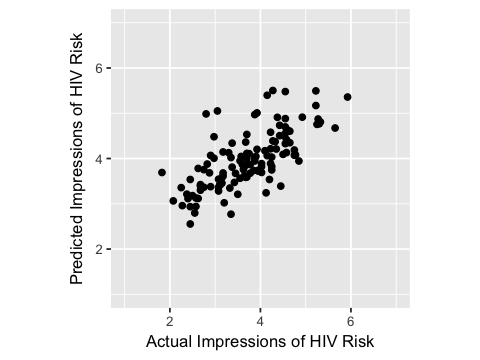

In [8]:
X_test <- as.matrix(test_data[,2:57])
X_test <- as.data.frame(X_test)
pred_values <- predict.lm(RegModel.reduced, X_test);

# How well do the predicted data (predicted HIV risk) correlate with the measured data (veridical HIV risk)? 
cor.test(test_data$Risk, pred_values);

# Visualize the prediction as a scatterplot.
options(repr.plot.width=4, repr.plot.height=3)
qplot(test_data$Risk, pred_values, xlab = "Actual Impressions of HIV Risk", ylab = "Predicted Impressions of HIV Risk", 
    xlim = c(1,7), ylim = c(1,7), asp = 1) +
    theme(text = element_text(size=10))

rm(pred_values, coefficients.reduced, RegModel.reduced) 

we could also use the full model with all available cues, but that would be not advisable due to the large number of cues and collinearities, which make the model unstable

In [9]:
RegModel.full <- lm(Risk~., data=train_data)
coefficients.full = data.frame(coef(RegModel.full))

pred_values <- predict.lm(RegModel.full, X_test);
cor.test(test_data$Risk, pred_values);

rm(X_test, pred_values, coefficients.full, RegModel.full) 


	Pearson's product-moment correlation

data:  test_data$Risk and pred_values
t = 8.1305, df = 118, p-value = 4.824e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4705113 0.7029580
sample estimates:
      cor 
0.5992175 


#### 3.2 Linear Regression, reduced set of CONCRETE-only cues


	Pearson's product-moment correlation

data:  test_data$Risk and pred_values
t = 7.7631, df = 118, p-value = 3.326e-12
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4489833 0.6888813
sample estimates:
     cor 
0.581433 


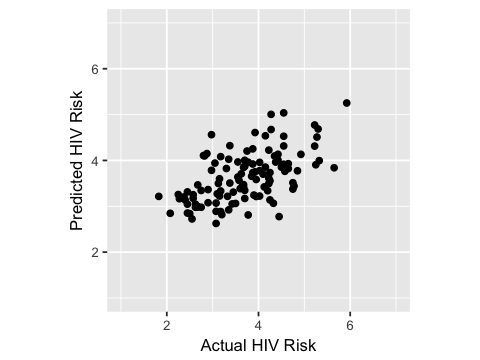

In [10]:
RegModel.reduced <- 
  lm(Risk~CUE2_Appearance2_Lot.of..vs..no..body.adornment_Abstract_0 +
       CUE8_Appearance8_Dark..vs..bright..clothes_Abstract_0+
       CUE12_Body3_Overweight..vs..underweight._Abstract_0+
       CUE15_Eyes1_Dark..vs..no.dark..rings.under.eyes_Abstract_0+
       CUE16_Eyes2_Reddened..vs..non.reddened..eyes_Abstract_0+
       CUE17_Eyes3_Dark..vs..bright..eyes_Abstract_0+
       CUE26_Face9_Red..vs..pale..cheeks_Abstract_0+
       CUE54_Mouth3_Full..vs..narrow..lips_Abstract_0+
       CUE55_Set1_Pallid..vs..colorful..background_Abstract_0+
       CUE57_Set3_Alcohol..vs..no.alcohol..visible_Abstract_0+
       CUE58_Set4_Picture.taken.inside..vs..outside._Abstract_0+
       CUE60_Set6_Cigarettes..vs..no.cigarettes..visible_Abstract_0+
       CUE65_Skin2_Pale..vs..tanned..skin_Abstract_0+
       CUE68_Skin5_Spotty..vs..spot.free..skin_Abstract_0+
       CUE69_Skin6_Greasy..vs..dry..skin_Abstract_0+
       CUE72_View2_Averted..vs..front.facing..gaze_Abstract_0,
   data=train_data)

#summary(RegModel.reduced)
coefficients.reduced = coef(RegModel.reduced)

X_test <- as.matrix(test_data[,2:57])
X_test <- as.data.frame(X_test)
pred_values <- predict.lm(RegModel.reduced, X_test);

# How well do the predicted data (predicted HIV risk) correlate with the measured data (veridical HIV risk)? In other words, how good does our prediction fit with what we actually observe?
cor.test(test_data$Risk, pred_values);

# Visualize the prediction as a scatterplot.
qplot(test_data$Risk, pred_values, xlab = "Actual HIV Risk", ylab = "Predicted HIV Risk", 
    xlim = c(1,7), ylim = c(1,7), asp = 1) +
    theme(text = element_text(size=10))

rm(X_test, pred_values, coefficients.reduced,  RegModel.reduced) 


#### 3.3 Compute the model for the training data using LASSO-Regression


In [11]:
l = length(train_data)

y_train <- as.matrix(train_data[,1])
X_train <- as.matrix(train_data[,2:l])

fit <- lars(X_train, y_train, type="lasso")
#summary(fit)

best_step <- fit$df[which.min(fit$RSS)] # select a step with a minimum error

predict lasso


	Pearson's product-moment correlation

data:  test_data$Risk and predictions$fit
t = 9.4985, df = 118, p-value = 3.092e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5430851 0.7491076
sample estimates:
      cor 
0.6582502 


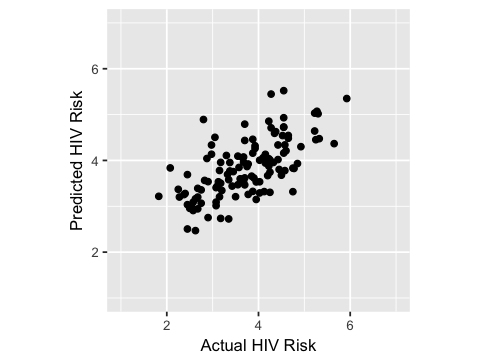

In [12]:
X_test <- as.matrix(test_data[,2:l])  # make predictions
predictions <- predict(fit, X_test, s=best_step, type="fit")

cor.test(test_data$Risk, predictions$fit); # summarize accuracy

qplot(test_data$Risk, predictions$fit, xlab = "Actual HIV Risk", ylab = "Predicted HIV Risk", 
    xlim = c(1,7), ylim = c(1,7), asp = 1) +
    theme(text = element_text(size=10))

### 3.4 Reduced LASSO-Regression with concrete cues only


[1] 32


	Pearson's product-moment correlation

data:  test_data$Risk and predictions$fit
t = 8.6062, df = 118, p-value = 3.836e-14
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4970763 0.7200809
sample estimates:
      cor 
0.6209896 


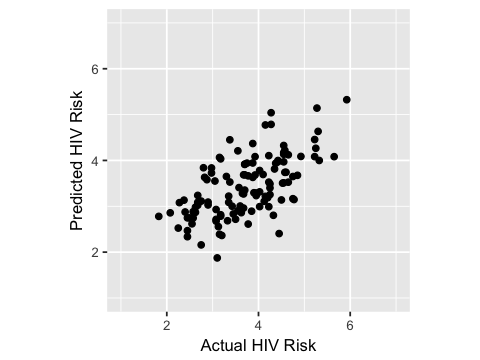

In [13]:
train_data$CUE4_Appearance4_Worn.out..vs..intact..clothes_Abstract_1=NULL
train_data$CUE5_Appearance5_Provocative..vs..reserved..clothes_Abstract_1=NULL
train_data$CUE6_Appearance6_Unconventional..vs..conventional..appearance_Abstract_1=NULL
train_data$CUE7_Appearance7_Fashionable..vs..unfashionable..appearance_Abstract_1=NULL
train_data$CUE9_Appearance9_Clean..vs..dirty..clothes_Abstract_1=NULL
train_data$CUE10_Body1_Tense..vs..relaxed..posture_Abstract_1=NULL
train_data$CUE11_Body2_Musculous..vs..not.musculous..stature_Abstract_1=NULL
train_data$CUE13_Body4_Well..vs..badly..proportioned.Stature_Abstract_1=NULL
train_data$CUE18_Face1_Happy..vs..sad..expression_Abstract_1=NULL
train_data$CUE19_Face2_Babyish..vs..mature..Face_Abstract_1=NULL
train_data$CUE20_Face3_Feminine..vs..masculine..face_Abstract_1=NULL
train_data$CUE21_Face4_Exhausted..vs..powerful..expression_Abstract_1=NULL
train_data$CUE23_Face6_Worn..vs..fresh..face_Abstract_1=NULL
train_data$CUE24_Face7_Worried..vs..unworried..expression_Abstract_1=NULL
train_data$CUE25_Face8_Ugly..vs..beautiful..face_Abstract_1=NULL
train_data$CUE28_Face11_Serious..vs..blithely..expression_Abstract_1=NULL
train_data$CUE29_Face12_Average..vs..unusual..face_Abstract_1=NULL
train_data$CUE30_Face13_Angry..vs..cheerful..expression_Abstract_1=NULL
train_data$CUE32_Face15_Friendly..vs..grumpy..expression_Abstract_1=NULL
train_data$CUE38_GenImp4_Southern..vs..nordic..type_Abstract_1=NULL
train_data$CUE48_Hair1_Ungroomed..vs..groomed..hair_Abstract_1=NULL
train_data$CUE50_Hair3_Fashionable..vs..unfashionable..hairstyle_Abstract_1=NULL
train_data$CUE56_Set2_Unorganized..vs..organized..background_Abstract_1=NULL
train_data$CUE64_Skin1_Unhealthy..vs..healthy..skin_Abstract_1=NULL
train_data$CUE71_View1_Coquettish..vs..no.coquettish..gaze_Abstract_1=NULL
train_data$CUE73_View3_Tired..vs..alert..gaze_Abstract_1=NULL

test_data$CUE4_Appearance4_Worn.out..vs..intact..clothes_Abstract_1=NULL
test_data$CUE5_Appearance5_Provocative..vs..reserved..clothes_Abstract_1=NULL
test_data$CUE6_Appearance6_Unconventional..vs..conventional..appearance_Abstract_1=NULL
test_data$CUE7_Appearance7_Fashionable..vs..unfashionable..appearance_Abstract_1=NULL
test_data$CUE9_Appearance9_Clean..vs..dirty..clothes_Abstract_1=NULL
test_data$CUE10_Body1_Tense..vs..relaxed..posture_Abstract_1=NULL
test_data$CUE11_Body2_Musculous..vs..not.musculous..stature_Abstract_1=NULL
test_data$CUE13_Body4_Well..vs..badly..proportioned.Stature_Abstract_1=NULL
test_data$CUE18_Face1_Happy..vs..sad..expression_Abstract_1=NULL
test_data$CUE19_Face2_Babyish..vs..mature..Face_Abstract_1=NULL
test_data$CUE20_Face3_Feminine..vs..masculine..face_Abstract_1=NULL
test_data$CUE21_Face4_Exhausted..vs..powerful..expression_Abstract_1=NULL
test_data$CUE23_Face6_Worn..vs..fresh..face_Abstract_1=NULL
test_data$CUE24_Face7_Worried..vs..unworried..expression_Abstract_1=NULL
test_data$CUE25_Face8_Ugly..vs..beautiful..face_Abstract_1=NULL
test_data$CUE28_Face11_Serious..vs..blithely..expression_Abstract_1=NULL
test_data$CUE29_Face12_Average..vs..unusual..face_Abstract_1=NULL
test_data$CUE30_Face13_Angry..vs..cheerful..expression_Abstract_1=NULL
test_data$CUE32_Face15_Friendly..vs..grumpy..expression_Abstract_1=NULL
test_data$CUE38_GenImp4_Southern..vs..nordic..type_Abstract_1=NULL
test_data$CUE48_Hair1_Ungroomed..vs..groomed..hair_Abstract_1=NULL
test_data$CUE50_Hair3_Fashionable..vs..unfashionable..hairstyle_Abstract_1=NULL
test_data$CUE56_Set2_Unorganized..vs..organized..background_Abstract_1=NULL
test_data$CUE64_Skin1_Unhealthy..vs..healthy..skin_Abstract_1=NULL
test_data$CUE71_View1_Coquettish..vs..no.coquettish..gaze_Abstract_1=NULL
test_data$CUE73_View3_Tired..vs..alert..gaze_Abstract_1=NULL

l = length(test_data)
l

y_train <- as.matrix(train_data[,1])
X_train <- as.matrix(train_data[,2:l])
fit <- lars(X_train, y_train, type="lasso")

best_step <- fit$df[which.min(fit$RSS)] # select a step with a minimum error


X_test <- as.matrix(test_data[,2:l])  # make predictions
predictions <- predict(fit, X_test, s=best_step, type="fit")

cor.test(test_data$Risk, predictions$fit); # summarize accuracy

qplot(test_data$Risk, predictions$fit, xlab = "Actual HIV Risk", ylab = "Predicted HIV Risk", 
    xlim = c(1,7), ylim = c(1,7), asp = 1) +
    theme(text = element_text(size=10))

### 4. General Impressions Correlations.

In [14]:
rm(list = ls())

train_data = read.csv("setA_001-120.txt", header =TRUE, sep = "\t"); 

traindf = data.frame(matrix(ncol = 0, nrow = 120))
traindf$Risk <- train_data$Risk      

traindf$SelfConfident <- train_data$CUE35_GenImp1_Self.confident..vs..not._Abstract_2               
traindf$Cautious <-train_data$CUE36_GenImp2_Cautious..vs..risk.seeking._Abstract_2                  
traindf$Uneducated <-train_data$CUE37_GenImp3_Uneducated..vs..educated._Abstract_2                 
traindf$Southern <-train_data$CUE38_GenImp4_Southern..vs..nordic..type_Abstract_1                     
traindf$Sporty <-train_data$CUE39_GenImp5_Sporty..vs..unsporty._Abstract_2                        
traindf$Scruffy <-train_data$CUE40_GenImp6_Scruffy..vs..kempt._Abstract_2               
traindf$Likeable <-train_data$CUE41_GenImp7_Likeable..vs..unsympathetic._Abstract_2              
traindf$Attractive <-train_data$CUE42_GenImp8_Attractive..vs..unattractive._Abstract_2            
traindf$Irresponsible <-train_data$CUE43_GenImp9_Irresponsible..vs..responsible._Abstract_2             
traindf$Homosexual <-train_data$CUE44_GenImp10_Homosexual..vs..heterosexual._Abstract_2                 
traindf$Popular <-train_data$CUE45_GenImp11_Popular..vs..unpopular._Abstract_2                   
traindf$Selfish <-train_data$CUE46_GenImp12_Selfish..vs..unselfish._Abstract_2              
traindf$Ill.looking <-train_data$CUE47_GenImp13_Ill.looking..vs..healthy.looking._Abstract_2

corrs_traindf <- cor(traindf)

rm(train_data, traindf)


test_data = read.csv("setB_121-240.txt", header =TRUE, sep = "\t"); 

testdf = data.frame(matrix(ncol = 0, nrow = 120))

testdf$Risk <- test_data$Risk       

testdf$SelfConfident <- test_data$CUE35_GenImp1_Self.confident..vs..not._Abstract_2               
testdf$Cautious <-test_data$CUE36_GenImp2_Cautious..vs..risk.seeking._Abstract_2                  
testdf$Uneducated <-test_data$CUE37_GenImp3_Uneducated..vs..educated._Abstract_2                 
testdf$Southern <-test_data$CUE38_GenImp4_Southern..vs..nordic..type_Abstract_1                     
testdf$Sporty <-test_data$CUE39_GenImp5_Sporty..vs..unsporty._Abstract_2                        
testdf$Scruffy <-test_data$CUE40_GenImp6_Scruffy..vs..kempt._Abstract_2               
testdf$Likeable <-test_data$CUE41_GenImp7_Likeable..vs..unsympathetic._Abstract_2              
testdf$Attractive <-test_data$CUE42_GenImp8_Attractive..vs..unattractive._Abstract_2            
testdf$Irresponsible <-test_data$CUE43_GenImp9_Irresponsible..vs..responsible._Abstract_2             
testdf$Homosexual <-test_data$CUE44_GenImp10_Homosexual..vs..heterosexual._Abstract_2                 
testdf$Popular <-test_data$CUE45_GenImp11_Popular..vs..unpopular._Abstract_2                   
testdf$Selfish <-test_data$CUE46_GenImp12_Selfish..vs..unselfish._Abstract_2              
testdf$Ill.looking <-test_data$CUE47_GenImp13_Ill.looking..vs..healthy.looking._Abstract_2

corrs_testdf <- cor(testdf)

rm(test_data, testdf)

round(corrs_traindf[,1],3)
round(corrs_testdf[,1],3)

round(cor(corrs_testdf[1,2:14], corrs_traindf[1,2:14]),2)

Risk SelfConfident      Cautious    Uneducated      Southern 
        1.000        -0.074        -0.349         0.555         0.258 
       Sporty       Scruffy      Likeable    Attractive Irresponsible 
       -0.029         0.269        -0.452         0.115         0.598 
   Homosexual       Popular       Selfish   Ill.looking 
        0.140        -0.220         0.427         0.320

Risk SelfConfident      Cautious    Uneducated      Southern 
        1.000         0.047        -0.365         0.548         0.413 
       Sporty       Scruffy      Likeable    Attractive Irresponsible 
        0.117         0.090        -0.362         0.084         0.619 
   Homosexual       Popular       Selfish   Ill.looking 
        0.132        -0.090         0.536         0.048

[1] 0.92

### 5. Train model on Risk, Trust, Health, Attractiveness - then predict on other variables in the test data

In [15]:
rm(list = ls())

train_data = read.csv("setA_001-120.txt", header =TRUE, sep = "\t"); 

In [16]:
RegModelRisk.reduced <- 
  lm(Risk~CUE2_Appearance2_Lot.of..vs..no..body.adornment_Abstract_0 +
       CUE4_Appearance4_Worn.out..vs..intact..clothes_Abstract_1+
       CUE5_Appearance5_Provocative..vs..reserved..clothes_Abstract_1+
       CUE6_Appearance6_Unconventional..vs..conventional..appearance_Abstract_1+
       CUE8_Appearance8_Dark..vs..bright..clothes_Abstract_0+
       CUE10_Body1_Tense..vs..relaxed..posture_Abstract_1+
       CUE12_Body3_Overweight..vs..underweight._Abstract_0+
       CUE15_Eyes1_Dark..vs..no.dark..rings.under.eyes_Abstract_0+
       CUE16_Eyes2_Reddened..vs..non.reddened..eyes_Abstract_0+
       CUE17_Eyes3_Dark..vs..bright..eyes_Abstract_0+
       CUE18_Face1_Happy..vs..sad..expression_Abstract_1+
       CUE19_Face2_Babyish..vs..mature..Face_Abstract_1+
       CUE20_Face3_Feminine..vs..masculine..face_Abstract_1+
       CUE25_Face8_Ugly..vs..beautiful..face_Abstract_1+
       CUE26_Face9_Red..vs..pale..cheeks_Abstract_0+
       CUE54_Mouth3_Full..vs..narrow..lips_Abstract_0+
       CUE55_Set1_Pallid..vs..colorful..background_Abstract_0+
       CUE56_Set2_Unorganized..vs..organized..background_Abstract_1+
       CUE57_Set3_Alcohol..vs..no.alcohol..visible_Abstract_0+
       CUE58_Set4_Picture.taken.inside..vs..outside._Abstract_0+
       CUE60_Set6_Cigarettes..vs..no.cigarettes..visible_Abstract_0+
       CUE65_Skin2_Pale..vs..tanned..skin_Abstract_0+
       CUE68_Skin5_Spotty..vs..spot.free..skin_Abstract_0+
       CUE69_Skin6_Greasy..vs..dry..skin_Abstract_0+
       CUE72_View2_Averted..vs..front.facing..gaze_Abstract_0,
   data=train_data)

RegModelTrust.reduced <- 
  lm(Trust~CUE2_Appearance2_Lot.of..vs..no..body.adornment_Abstract_0 +
       CUE4_Appearance4_Worn.out..vs..intact..clothes_Abstract_1+
       CUE5_Appearance5_Provocative..vs..reserved..clothes_Abstract_1+
       CUE6_Appearance6_Unconventional..vs..conventional..appearance_Abstract_1+
       CUE8_Appearance8_Dark..vs..bright..clothes_Abstract_0+
       CUE10_Body1_Tense..vs..relaxed..posture_Abstract_1+
       CUE12_Body3_Overweight..vs..underweight._Abstract_0+
       CUE15_Eyes1_Dark..vs..no.dark..rings.under.eyes_Abstract_0+
       CUE16_Eyes2_Reddened..vs..non.reddened..eyes_Abstract_0+
       CUE17_Eyes3_Dark..vs..bright..eyes_Abstract_0+
       CUE18_Face1_Happy..vs..sad..expression_Abstract_1+
       CUE19_Face2_Babyish..vs..mature..Face_Abstract_1+
       CUE20_Face3_Feminine..vs..masculine..face_Abstract_1+
       CUE25_Face8_Ugly..vs..beautiful..face_Abstract_1+
       CUE26_Face9_Red..vs..pale..cheeks_Abstract_0+
       CUE54_Mouth3_Full..vs..narrow..lips_Abstract_0+
       CUE55_Set1_Pallid..vs..colorful..background_Abstract_0+
       CUE56_Set2_Unorganized..vs..organized..background_Abstract_1+
       CUE57_Set3_Alcohol..vs..no.alcohol..visible_Abstract_0+
       CUE58_Set4_Picture.taken.inside..vs..outside._Abstract_0+
       CUE60_Set6_Cigarettes..vs..no.cigarettes..visible_Abstract_0+
       CUE65_Skin2_Pale..vs..tanned..skin_Abstract_0+
       CUE68_Skin5_Spotty..vs..spot.free..skin_Abstract_0+
       CUE69_Skin6_Greasy..vs..dry..skin_Abstract_0+
       CUE72_View2_Averted..vs..front.facing..gaze_Abstract_0,
   data=train_data)

RegModelAttractiveness.reduced <- 
  lm(Attractiveness~CUE2_Appearance2_Lot.of..vs..no..body.adornment_Abstract_0 +
       CUE4_Appearance4_Worn.out..vs..intact..clothes_Abstract_1+
       CUE5_Appearance5_Provocative..vs..reserved..clothes_Abstract_1+
       CUE6_Appearance6_Unconventional..vs..conventional..appearance_Abstract_1+
       CUE8_Appearance8_Dark..vs..bright..clothes_Abstract_0+
       CUE10_Body1_Tense..vs..relaxed..posture_Abstract_1+
       CUE12_Body3_Overweight..vs..underweight._Abstract_0+
       CUE15_Eyes1_Dark..vs..no.dark..rings.under.eyes_Abstract_0+
       CUE16_Eyes2_Reddened..vs..non.reddened..eyes_Abstract_0+
       CUE17_Eyes3_Dark..vs..bright..eyes_Abstract_0+
       CUE18_Face1_Happy..vs..sad..expression_Abstract_1+
       CUE19_Face2_Babyish..vs..mature..Face_Abstract_1+
       CUE20_Face3_Feminine..vs..masculine..face_Abstract_1+
       CUE25_Face8_Ugly..vs..beautiful..face_Abstract_1+
       CUE26_Face9_Red..vs..pale..cheeks_Abstract_0+
       CUE54_Mouth3_Full..vs..narrow..lips_Abstract_0+
       CUE55_Set1_Pallid..vs..colorful..background_Abstract_0+
       CUE56_Set2_Unorganized..vs..organized..background_Abstract_1+
       CUE57_Set3_Alcohol..vs..no.alcohol..visible_Abstract_0+
       CUE58_Set4_Picture.taken.inside..vs..outside._Abstract_0+
       CUE60_Set6_Cigarettes..vs..no.cigarettes..visible_Abstract_0+
       CUE65_Skin2_Pale..vs..tanned..skin_Abstract_0+
       CUE68_Skin5_Spotty..vs..spot.free..skin_Abstract_0+
       CUE69_Skin6_Greasy..vs..dry..skin_Abstract_0+
       CUE72_View2_Averted..vs..front.facing..gaze_Abstract_0,
   data=train_data)


RegModelHealth.reduced <- 
  lm(Health~CUE2_Appearance2_Lot.of..vs..no..body.adornment_Abstract_0 +
       CUE4_Appearance4_Worn.out..vs..intact..clothes_Abstract_1+
       CUE5_Appearance5_Provocative..vs..reserved..clothes_Abstract_1+
       CUE6_Appearance6_Unconventional..vs..conventional..appearance_Abstract_1+
       CUE8_Appearance8_Dark..vs..bright..clothes_Abstract_0+
       CUE10_Body1_Tense..vs..relaxed..posture_Abstract_1+
       CUE12_Body3_Overweight..vs..underweight._Abstract_0+
       CUE15_Eyes1_Dark..vs..no.dark..rings.under.eyes_Abstract_0+
       CUE16_Eyes2_Reddened..vs..non.reddened..eyes_Abstract_0+
       CUE17_Eyes3_Dark..vs..bright..eyes_Abstract_0+
       CUE18_Face1_Happy..vs..sad..expression_Abstract_1+
       CUE19_Face2_Babyish..vs..mature..Face_Abstract_1+
       CUE20_Face3_Feminine..vs..masculine..face_Abstract_1+
       CUE25_Face8_Ugly..vs..beautiful..face_Abstract_1+
       CUE26_Face9_Red..vs..pale..cheeks_Abstract_0+
       CUE54_Mouth3_Full..vs..narrow..lips_Abstract_0+
       CUE55_Set1_Pallid..vs..colorful..background_Abstract_0+
       CUE56_Set2_Unorganized..vs..organized..background_Abstract_1+
       CUE57_Set3_Alcohol..vs..no.alcohol..visible_Abstract_0+
       CUE58_Set4_Picture.taken.inside..vs..outside._Abstract_0+
       CUE60_Set6_Cigarettes..vs..no.cigarettes..visible_Abstract_0+
       CUE65_Skin2_Pale..vs..tanned..skin_Abstract_0+
       CUE68_Skin5_Spotty..vs..spot.free..skin_Abstract_0+
       CUE69_Skin6_Greasy..vs..dry..skin_Abstract_0+
       CUE72_View2_Averted..vs..front.facing..gaze_Abstract_0,
   data=train_data)

In [17]:
test_data = read.csv("setB_121-240.txt", header =TRUE, sep = "\t"); 

Trust = test_data$Trust 
Health = test_data$Health
Attractiveness = test_data$Attractiveness
Risk = test_data$Risk

realratings = data.frame(Trust, 
                         Health, 
                         Attractiveness, 
                         Risk)
rm(Trust, Health, Attractiveness, Risk)

In [18]:
# reduce the test_data by the same variables as the train_data
test_data$CUE3_Appearance3_Unshaved..vs..shaved._Abstract_0 <- NULL
test_data$CUE34_Face17_Strong..vs..no..growth.of.beard_Abstract_0 <- NULL
test_data$CUE53_Mouth2_Yellow..vs..white..teeth_Abstract_0 <- NULL
test_data$CUE62_Set8_Dark..vs..well.lit..background_Abstract_0 <- NULL
test_data$No <- NULL
test_data$Sex <- NULL
test_data$BildNr <- NULL
test_data$Trust <- NULL
test_data$Health <- NULL
test_data$Attractiveness <- NULL
test_data$CUE35_GenImp1_Self.confident..vs..not._Abstract_2=NULL                
test_data$CUE36_GenImp2_Cautious..vs..risk.seeking._Abstract_2=NULL                  
test_data$CUE37_GenImp3_Uneducated..vs..educated._Abstract_2=NULL                 
test_data$CUE38_GenImp4_Southern..vs..nordic..type_Abstract_1=NULL                     
test_data$CUE39_GenImp5_Sporty..vs..unsporty._Abstract_2=NULL                        
test_data$CUE40_GenImp6_Scruffy..vs..kempt._Abstract_2=NULL               
test_data$CUE41_GenImp7_Likeable..vs..unsympathetic._Abstract_2=NULL              
test_data$CUE42_GenImp8_Attractive..vs..unattractive._Abstract_2=NULL            
test_data$CUE43_GenImp9_Irresponsible..vs..responsible._Abstract_2=NULL             
test_data$CUE44_GenImp10_Homosexual..vs..heterosexual._Abstract_2=NULL                 
test_data$CUE45_GenImp11_Popular..vs..unpopular._Abstract_2=NULL                   
test_data$CUE46_GenImp12_Selfish..vs..unselfish._Abstract_2=NULL              
test_data$CUE47_GenImp13_Ill.looking..vs..healthy.looking._Abstract_2=NULL


In [19]:
X_test <- as.matrix(test_data[,2:57])
X_test <- as.data.frame(X_test)

pred_values_riskmodel <- predict.lm(RegModelRisk.reduced, X_test);
cor(realratings$Risk, pred_values_riskmodel);
cor(realratings$Trust, pred_values_riskmodel);
cor(realratings$Health, pred_values_riskmodel);
cor(realratings$Attractiveness, pred_values_riskmodel);

print('-------')
pred_values_trustmodel <- predict.lm(RegModelTrust.reduced, X_test);
cor.test(realratings$Risk, pred_values_trustmodel);
cor(realratings$Trust, pred_values_trustmodel);
cor(realratings$Health, pred_values_trustmodel);
cor(realratings$Attractiveness, pred_values_trustmodel);

print('-------')
pred_values_healthmodel <- predict.lm(RegModelHealth.reduced, X_test);
cor(realratings$Risk, pred_values_healthmodel);
cor(realratings$Trust, pred_values_healthmodel);
cor(realratings$Health, pred_values_healthmodel);
cor(realratings$Attractiveness, pred_values_healthmodel);

print('-------')
pred_values_attractivenessmodel <- predict.lm(RegModelAttractiveness.reduced, X_test);
cor(realratings$Risk, pred_values_attractivenessmodel);
cor(realratings$Trust, pred_values_attractivenessmodel);
cor(realratings$Health, pred_values_attractivenessmodel);
cor(realratings$Attractiveness, pred_values_attractivenessmodel);



[1] 0.7000889

[1] -0.702087

[1] -0.3443952

[1] 0.01852172

[1] "-------"



	Pearson's product-moment correlation

data:  realratings$Risk and pred_values_trustmodel
t = -6.8512, df = 118, p-value = 3.535e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6505032 -0.3916716
sample estimates:
       cor 
-0.5334619 


[1] 0.7070154

[1] 0.4844222

[1] 0.3035869

[1] "-------"


[1] -0.1789456

[1] 0.4283765

[1] 0.7735014

[1] 0.7003482

[1] "-------"


[1] 0.06692382

[1] 0.1861235

[1] 0.6387939

[1] 0.8475284